In [13]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
# from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomResizedCrop, Normalize
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm
from datetime import datetime as dt
import os
import random

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Setting the data for testing

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

print(X.shape, y.shape)

(1000, 5) (1000, 1)


# Data configuration

In [4]:
%%writefile data_config/data_prep.py

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(X.shape[0] * 0.8)
valid_size = X.shape[0] - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=32
)

Overwriting data_config/data_prep.py


# Model configuration

In [5]:
%load_ext tensorboard
%tensorboard --logdir summary

Reusing TensorBoard on port 6006 (pid 17044), started 1 day, 22:47:47 ago. (Use '!kill 17044' to kill it.)

In [6]:
%%writefile model_config/model_setting.py

def create_train_step_fn(model, loss_fn, optimizer):
    def output_train_step_loss(X, y):
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return output_train_step_loss

def create_valid_step_fn(model, loss_fn):
    def output_valid_step_loss(X, y):
        model.eval()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        return loss.item()
    return output_valid_step_loss

def get_mini_batch_loss(device, data_loader, step_fn):
    mini_batch_losses = []
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        batch_loss = step_fn(X_batch, y_batch)
        mini_batch_losses.append(batch_loss)
    
    return np.mean(mini_batch_losses)

lr = 0.01

torch.manual_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(5, 1)).to(device)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

train_step_fn = create_train_step_fn(model, loss_fn, optimizer)
valid_step_fn = create_valid_step_fn(model, loss_fn)

tensorboard_writer = SummaryWriter('summary/simple_linear_reg')

Overwriting model_config/model_setting.py


# Model training

In [7]:
%%writefile model/train.py

n_epochs = 100

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = get_mini_batch_loss(device=device, data_loader=train_loader, step_fn=train_step_fn)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = get_mini_batch_loss(device=device, data_loader=valid_loader, step_fn=valid_step_fn)
        valid_losses.append(valid_loss)

    tensorboard_writer.add_scalars(
        main_tag = 'losses',
        tag_scalar_dict = {
            'train': train_loss,
            'validation': valid_loss
        },
        global_step = epoch
    )

tensorboard_writer.close()

Overwriting model/train.py


In [8]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i model/train.py

In [9]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

# DLAssistant class creation

In [10]:
%%writefile data_config/data_prep_v2.py

class CustomDataset(Dataset):

    def __init__(self, X, y, X_transform=None):
        self.X = X
        self.y = y 
        self.X_transform = X_transform

    def __getitem__(self, index):
        X = self.X[index]

        if self.X_transform is not None:
            X = self.X_transform(X)

        return X, self.y[index]

    def __len__(self):
        return len(self.X)

def index_splitter(data_size, splits, seed=13):
    idxs = torch.arange(data_size)
    splits_tensor = torch.as_tensor(splits)
    multiplier = data_size / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    diff = data_size - splits_tensor.sum()
    splits_tensor[0] += diff
    torch.manual_seed(seed)
    return random_split(idxs, splits_tensor)

def create_balanced_sampler(y):

    classes, counts = y.unique(return_counts=True)
    weights = 1 / counts.float()
    sample_weights = weights[y.squeeze().long()]

    generator = torch.Generator()

    weighted_sampler = WeightedRandomSampler(
        weights=sample_weights,
        number_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

    return weighted_sampler

Overwriting data_config/data_prep_v2.py


In [22]:
%%writefile assistent/model.py
class DLAssistant(object):
    
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = None
        self.valid_loader = None
        self.tensorboard_writer = None

        self.train_losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._create_train_step_fn()
        self.valid_step_fn = self._create_valid_step_fn()

    def to(self, device):

        try:
            self.model = self.model.to(device)
            self.device = device
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = self.model.to(self.device)
            print(f"{device} device is not accessable!!!\n{self.device} is used!!!")

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, log_dir='summary'):
        
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        name_suffix = dt.now().strftime('%Y%m%d_%H%M%S')
        full_name = f"{log_dir}/{name}_{name_suffix}"
        self.tensorboard_writer = SummaryWriter(full_name)

    def _create_train_step_fn(self):

        def get_train_loss(X, y):
            self.model.train()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        
        return get_train_loss
    
    def _create_valid_step_fn(self):
        
        def get_valid_loss(X, y):
            self.model.eval()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            return loss.item()
        
        return get_valid_loss
    
    def _get_mini_batch_loss(self, validation=False):

        if validation:
            data_loader = self.valid_loader
            step_fn = self.valid_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        mini_batch_losses = []

        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(X_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        return np.mean(mini_batch_losses)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
    
    def train(self, n_epochs, seed=42):

        self.total_epochs += 1

        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):

            train_loss = self._get_mini_batch_loss()
            self.train_losses.append(train_loss)

            with torch.no_grad():
                valid_loss = self._get_mini_batch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            if self.tensorboard_writer is not None:
                scalar_dict = {'train': train_loss}
                if self.valid_loader is not None:
                    scalar_dict.update({'validation': valid_loss})
                self.tensorboard_writer.add_scalars(
                    main_tag = 'losses',
                    tag_scalar_dict = scalar_dict,
                    global_step = epoch
                )

        if self.tensorboard_writer is not None:
            self.tensorboard_writer.flush()

    def show_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.train_losses, label='train', c='blue')
        if self.valid_loader is not None:
            plt.plot(self.valid_losses, label='valid', c='orange')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        return fig
    
    def save_results(self, filepath):
        checkpoint_dict = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'total_epochs': self.total_epochs,
            'train_losses': self.train_losses,
            'valid_losses': self.valid_losses
        }
        torch.save(checkpoint_dict, filepath)

    def load_states(self, filepath):
        checkpoint_dict = torch.load(filepath)
        self.model.load_state_dict(checkpoint_dict['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        self.total_epochs = checkpoint_dict['total_epochs']
        self.train_losses = checkpoint_dict['train_losses']
        self.valid_losses = checkpoint_dict['valid_losses']

        self.model.train()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X).float()
        X_tensor = X_tensor.to(self.device)
        pred_y = self.model(X_tensor).detach().cpu().numpy()
        self.model.train()
        return pred_y

    def count_parameters(self):
        parameter_number_list = [p.numel() for p in self.model.parameters() if p.requires_grad]
        return sum(parameter_number_list)

Overwriting assistent/model.py


In [23]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i assistent/model.py

dl_assistent = DLAssistant(model, loss_fn, optimizer)
dl_assistent.set_loaders(train_loader, valid_loader)
dl_assistent.set_tensorboard(name='class_linear_reg')
dl_assistent.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

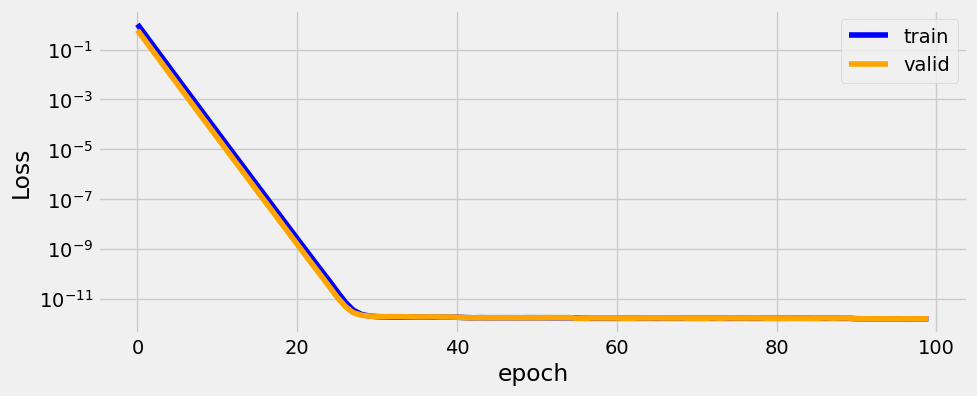

In [24]:
loss_fig = dl_assistent.show_losses();

In [25]:
dl_assistent.model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

In [54]:
dl_assistent.save_results('checkpoint.pth')

In [55]:
dl_assistent.load_states('checkpoint.pth')

In [59]:
X_test = np.random.randn(5, 5)

model_pred = dl_assistent.predict(X_test)
model_pred

array([[-1.5417023 ],
       [-1.1239675 ],
       [-0.59521425],
       [-0.5070373 ],
       [-1.8620882 ]], dtype=float32)

In [26]:
dl_assistent.count_parameters()

6